# Logistic Regression

Logistic regression is a *binary classification algorithm*.

Text(0.5, 1.0, 'Data')

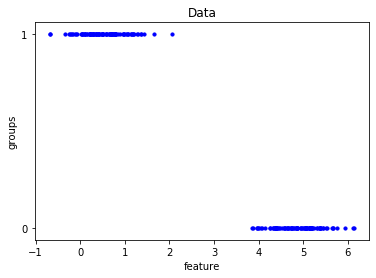

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split


# create linearly separable data
sep = False
while not sep:
    X, Y = make_blobs(n_samples=200, n_features
                      =1, centers=2, cluster_std=0.5, center_box=(0, 10))
    sep = True
    for x_1 in X[Y == 1]:
        for x_0 in X[Y == 0]:
            if Y[X.argmin()] == 0 and x_0 > x_1:
                sep = False
            elif x_0 < x_1:
                sep = False
         
X = np.hstack([X, np.ones((X.shape[0], 1))])

                
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

plt.scatter(X[:, 0], Y, s=10, c='b')
plt.xlabel('feature')
plt.ylabel('groups')
plt.yticks([0, 1])
plt.title('Data')

## Binary target

### Sigmoid function

We have to fit a **model** trough our data.  
The *sigmoid* (also called *logistic*) function is used:
$$\boxed{
\sigma(x) = \frac{1}{1 + e^{-x}}
}$$

It produce an 'S' shape like function that stays between 0 and 1

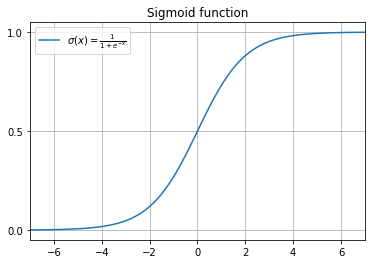

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

xs_sig = np.linspace(-7, 7, 100)
ys_sig = sigmoid(xs_sig)
plt.plot(xs_sig, ys_sig, label=r'$\sigma(x) = {\frac{1}{1 + e^{-x}}}$')
plt.yticks([0, 0.5, 1])
plt.xlim([-7, 7])
plt.legend()
plt.grid()
plt.title('Sigmoid function')
plt.show()

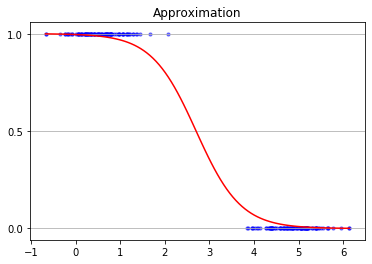

In [3]:
#  helper function for approximation
def sigmoid_mu_s(x, mu, s):
    return 1 / (1 + np.exp(-(x + mu) / s))

plt.scatter(X[:, 0], Y, s=10, c='b', alpha=0.5)
sig_x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_flip = 1 if Y[X[:, 0].argmin()] == 0 else -1
sig_y = sigmoid_mu_s(sig_x, -X[:, 0].mean(), y_flip * 0.5)
plt.plot(sig_x, sig_y, c='r')
plt.yticks([0, 0.5, 1])
plt.grid(axis='y')
plt.title('Approximation')
plt.show()

### Hypothesis and Prediction

We can tweak the sigmoid function by passing the dot product of $x$ (vector of feature) and $\theta$ (the vector of weights).

$$h(x) = \sigma(x \cdot \theta) = \sigma(\theta_0 x_0 + \theta_1 x_1 + \cdots + \theta_n x_n)$$
$x_0$ being equal to 1.  
$\theta$ is not a parameter of $h$ because it's considered as a constant.

$h$ is our hypothesis function. It return a probability of an $x$ to belong to one of the group.  
To predict some new $x$ we input it to $h$ with the weights and see if the returned value if above or below 0.5.

$$
\text{prediction} =
    \begin{cases} 
        1, & h(x) \ge 0.5 \\
        0, & h(x) \lt 0.5
    \end{cases}
$$

This is equivalent to:

$$
\text{prediction} =
    \begin{cases} 
        1, & x \cdot \theta \ge 0 \\
        0, & x \cdot \theta \lt 0
    \end{cases}
$$

Indeed, in the sigmoid funcion:  
* $x$ is *above* 0 then $e^{-x}$ tend to be small, $\frac{1}{1 + \text{small number}} \approx 1$.  
* $x$ is *below* 0 then $e^{-x}$ tend to be big, $\frac{1}{1 + \text{big number}} \approx 0$. 

Therefore, a prediction can be visualized by projecting $x$ onto $\theta$.  
It will be more relevant the more the two vectors go in the same direction
(or opposite direction for negative projection),
for exemple if $x \cdot \theta = 0$ then $x$ is perpendicular to $\theta$,
$h(x) = 0.5$ right in the middle of the sigmoid function,
the prediction become more irelevant as $x \cdot \theta$ tend to 0.

In [4]:
def hypothesis(x, theta):
    # suppose that x_0 = 1 and isn't mentionned
    return sigmoid(x.dot(theta))


def predict(x, theta):
    return int(hypothesis(x, theta) >= 0.5)  #  a bit more clear
    # or
    return int(x.dot(theta) >= 0)
    # there is a nice vector interpretation for this one
    # and it probably compute faster

### Cost function

We have to evaluate our model by introducing a cost function, this one is called the *logloss*

For a single $x$:
$$
j(h(x), y) = 
    \begin{cases} 
        -\ln(h(x)),     & y = 1 \\
        -\ln(1 - h(x)), & y = 0 
    \end{cases}
$$
It can be rewritten as a single continuous function:
$$ j(h(x), y) = -y \ln(h(x)) - (1 - y) \ln(1 - h(x))$$

Even if it may seem more complicated at first sight, it's just a switch with the values of $y$.  
- if $y = 1$ then $- (1 - y) \ln(1 - h(x)) = 0$ and the $-\ln(h(x))$ stays.
- if $y = 0$ then $-y \ln(h(x)) = 0$            and the $-\ln(1 - h(x))$ stays.

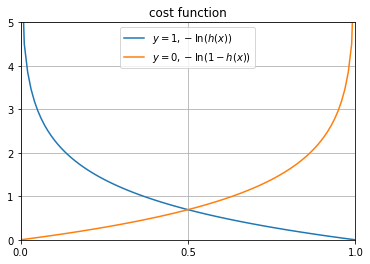

In [5]:
xs_log = np.linspace(0.001, 0.999, 100)
ys_0 = [-np.log(1 - x) for x in xs_log]
ys_1 = [-np.log(x) for x in xs_log]
plt.plot(xs_log, ys_1, label=r'$y = 1, -\ln(h(x))$')
plt.plot(xs_log, ys_0, label=r'$y = 0, -\ln(1 - h(x))$')
plt.ylim([0, 5])
plt.xlim([0, 1])
plt.xticks([0, 0.5, 1])
plt.legend()
plt.grid()
plt.title('cost function')
plt.show()

In [6]:
def logloss(x, y, theta):
    if y == 1:
        return -np.log(hypothesis(x, theta))
    elif y == 0:
        return -np.log(1 - hypothesis(x, theta))
    #  or (less obvious)
    return -y * np.log(hypothesis(x, theta)) - (1 - y) * np.log(1 - hypothesis(x, theta))

We can see that if $y$ was suppose to be 0 but is close to 1, the cost will be high.  
Same logic if $y$ was suppose to be 1 but is close to 0.

Then we generalize the cost function for all $x$:
$$J(\theta) = \frac{1}{n} \sum_{i = 1}^{n} j(h(x_i), y_i)$$
$n$ is the number of elements in $X$ and $Y$.

In [7]:
def cost(xs, ys, theta):
    return sum([logloss(x, y, theta) for x, y in zip(xs, ys)]) / len(xs)

### Gradient descent

Finally, use gradient descent to minimize the cost function:

$$\theta_i := \theta_i - \alpha \frac{\partial}{\partial \theta_i} J(\theta)\ \text{ for } i = 1, ..., n$$

Or with gradient notation:

$$ \theta := \theta - \alpha \nabla J(\theta)$$


$\alpha$ is the learning rate (how fast we want the step to be).  
Since $\theta_i$ is only used in the dot product, all of them will have similar partial derivative.

let $z = x \cdot \theta_j$

$\newcommand{\pt}{\frac{\partial}{\partial \theta_j}}$
$$
\begin{align}
      & \pt J(\theta) \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n} j(h(x_i, \theta), y_i) \right] \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n}
        (-y_i \ln(h(x_i, \theta)) - (1 - y_i) \ln(1 - h(x_i, \theta))) \right] \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n}
        (-y_i \ln(\sigma(z)) - (1 - y_i) \ln(1 - \sigma(z))) \right] \\
    = & \pt \left[ \frac{1}{n} \sum_{i = 1}^{n}
        (-y_i \ln(\frac{1}{1 + e^{-z}}) -
        (1 - y_i) \ln(1 - \frac{1}{1 + e^{-z}})) \right] \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \pt \left[ 
        -y_i \ln(\frac{1}{1 + e^{-z}}) -
        (1 - y_i) \ln(1 - \frac{1}{1 + e^{-z}}) \right] \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i \pt \left[ \ln(\frac{1}{1 + e^{-z}}) \right] -
        (1 - y_i) \pt \left[ \ln(1 - \frac{1}{1 + e^{-z}}) \right] \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i(1 + e^{-z}) \pt \left[ \frac{1}{1 + e^{-z}} \right]
        - (1 - y_i) \frac{1}{1 - \frac{1}{1 + e^{-z}}} \pt \left[ 1 - \frac{1}{1 + e^{-z}} \right]
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i(1 + e^{-z}) \pt \left[ \frac{1}{1 + e^{-z}} \right]
        - (1 - y_i) \frac{1 + e^{-z}}{e^{-z}} (-1) \pt \left[ \frac{1}{1 + e^{-z}} \right]
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i(1 + e^{-z}) \frac{e^{-z}}{(1 + e^{-z})^2} \pt z
        - (1 - y_i) \frac{1 + e^{-z}}{e^{-z}} (-1) \frac{e^{-z}}{(1 + e^{-z})^2} \pt z
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        -y_i \frac{e^{-z}}{1 + e^{-z}} x_{ij}
        + (1 - y_i) \frac{1}{1 + e^{-z}} x_{ij}
        \right) \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        \frac{-y_i e^{-z}}{1 + e^{-z}}
        + \frac{(1 - y_i)}{1 + e^{-z}} \right) x_{ij} \\
    = & \frac{1}{n} \sum_{i = 1}^{n} \left(
        \frac{-y_i e^{-z} + 1 - y_i}{1 + e^{-z}} \right) x_{ij} \\
\end{align}
$$

$$
\boxed{
    = \frac{1}{n} \sum_{i = 1}^{n} (h(x_i) - y_i) x_{ij}
}$$

In [8]:
def gradient(xs, ys, theta):
    g = np.array([])
    for j in range(len(theta)):
        g = np.append(g, [sum([(hypothesis(x, theta) - y) * x[j]
                          for x, y in zip(xs, ys)]) / len(xs)],
                      axis=0)
    return g

In [9]:
def gradient_descent(xs, ys, theta, alpha=1, epoch=100):
    for _ in range(epoch):
        theta = theta - alpha * gradient(xs, ys, theta)     
    return theta

In [10]:
theta_binary = np.random.randn(len(X_train[0]))
theta_binary = gradient_descent(X_train, Y_train, theta_binary, 2, 2000)
print('weights:  ', *theta_binary)
print('train cost:', cost(X_train, Y_train, theta_binary))
print('test cost: ', cost(X_test, Y_test, theta_binary))

weights:   -3.9825852503712964 10.630321833954772
train cost: 0.0013520554107438081
test cost:  0.0010672371683545642


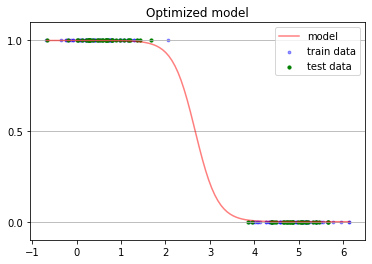

In [11]:
plt.scatter(X_train[:, 0], Y_train, s=8, c='b', alpha=0.4, label='train data')
plt.scatter(X_test[:, 0], Y_test, s=10, c='g', label='test data')
sig_x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
sig_y = [hypothesis(np.array([x, 1]), theta_binary) for x in sig_x]
plt.plot(sig_x, sig_y, c='r', alpha=0.5, label='model')
plt.yticks([0, 0.5, 1])
plt.ylim([-0.1, 1.1])
plt.legend()
plt.grid(axis='y')
plt.title('Optimized model')
plt.show()

## One vs all

What if we don't have a binary target but many groups (>2) to classify.  
It's in this that one vs all is applied.

Here, there is 2 features and 3 categories.

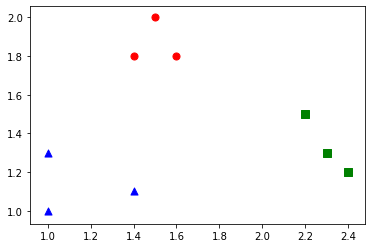

In [12]:
xs_oa = np.array([[1, 1], [1, 1.3], [1.4, 1.1],
               [1.5, 2], [1.6, 1.8], [1.4, 1.8],
               [2.4, 1.2], [2.2, 1.5], [2.3, 1.3]])
ys_oa = np.array([0, 0, 0,
               1, 1, 1,
               2, 2, 2])

xs_oa = np.hstack([xs_oa, np.ones((xs_oa.shape[0], 1))])

xs_plot_spec = [
    {'marker': '^', 'c': 'b', 's': 50},
    {'marker': 'o', 'c': 'r', 's': 50},
    {'marker': 's', 'c': 'g', 's': 50}
]

def plot_onevsall(xs, ys):
    for i, y in enumerate(ys):
        plt.scatter(xs[i,0], xs[i,1], **xs_plot_spec[y])
        
plot_onevsall(xs_oa, ys_oa)
plt.show()

The tricks is to create an hypothesis function for every target.  
Each of those will compare his target to all the other one.

For example the hypothesis function for *circle* will separate it from *triangle* and *square*

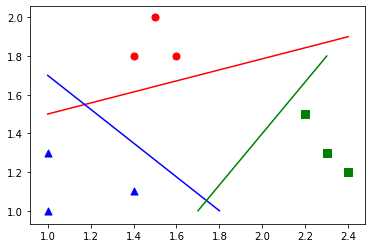

In [13]:
plot_onevsall(xs_oa, ys_oa)
plt.plot([1.0, 2.4], [1.5, 1.9], c='r')
plt.plot([1.0, 1.8], [1.7, 1.0], c='b')
plt.plot([1.7, 2.3], [1.0, 1.8], c='g')
plt.show()

In [14]:
def train_against(xs, ys, theta, one, alpha, epoch):
    ys_ally = ys.copy()
    ys_ally[ys == one] = 0
    ys_ally[ys != one] = 1
    return gradient_descent(xs, ys_ally, theta, alpha, epoch)

def train_thetas(xs, ys, theta, alpha=1, epoch=1000):
    thetas = []
    for i in np.unique(ys):
        thetas.append(train_against(xs, ys, theta, i, alpha, epoch))
    return thetas

In [15]:
theta_oa = np.random.randn(len(xs_oa[0]))
thetas_oa = train_thetas(xs_oa, ys_oa, theta_oa, alpha=1, epoch=1000)
thetas_oa

[array([  5.0954313 ,   6.39133932, -16.0566276 ]),
 array([  3.21562051, -10.74806413,  12.21725452]),
 array([-9.47029824,  7.01739702,  7.74698696])]

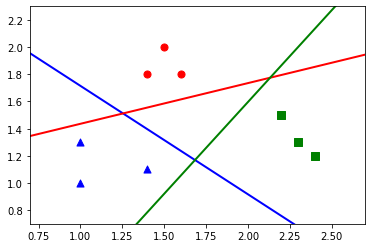

In [16]:
plot_onevsall(xs_oa, ys_oa)

def plot_boundaries(xs, thetas):
    for i, ti in enumerate(thetas):
        xs_ti = np.array([min(xs[:, 1]) - 2, max(xs[:, 1]) + 2])
        ys_ti = (-1 / ti[1]) * (ti[0] * xs_ti + ti[2])  # from https://utkuufuk.com/2018/05/19/binary-logistic-regression/
        plt.plot(xs_ti, ys_ti, linewidth=2, c=xs_plot_spec[i]['c'])

plt.xlim([xs_oa[:, 0].min() - 0.3, xs_oa[:, 0].max() + 0.3])
plt.ylim([xs_oa[:, 1].min() - 0.3, xs_oa[:, 1].max() + 0.3])
plot_boundaries(xs_oa, thetas_oa)
plt.show()

### Prediction

To make a prediction we get the hypothesis for each group $h^{(i)}(x)$, the predicted group is then $\max_i h^{(i)}(x)$.

In [19]:
def make_prediction(x, thetas):
    ps = [hypothesis(x, ti) for ti in thetas]
    return ps.index(min(ps))    

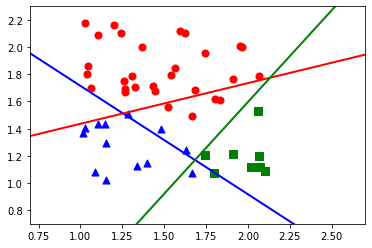

In [20]:
xs_pred = 1.2 * np.random.rand(50, 2) + 1
xs_pred = np.hstack([xs_pred, np.ones((xs_pred.shape[0], 1))])

ys_pred = np.array([make_prediction(x, thetas_oa) for x in xs_pred])
plot_onevsall(xs_pred, ys_pred)
plt.xlim([xs_oa[:, 0].min() - 0.3, xs_oa[:, 0].max() + 0.3])
plt.ylim([xs_oa[:, 1].min() - 0.3, xs_oa[:, 1].max() + 0.3])
plot_boundaries(xs_oa, thetas_oa)